# Image Segmentation Using RG Chromaticity and Gaussian Distribution

## Necessary Imports

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread, imshow
from matplotlib import cm
from matplotlib import colors
from matplotlib.patches import Rectangle
from skimage.color import rgb2yuv, yuv2rgb

## RG Chromaticity and Guassian Mask

### RG Chromaticity:

In [166]:
def RG_chromaticity(image):

  '''
  This function converts RGB space to 
  rg space. (Finds proportions)
  r = R / (R + G + B)
  g = G / (R + G + B)
  '''
  type(image)
  r = image[:,:,0]*1.0 / image.sum(axis=2)
  g = image[:,:,1]*1.0 / image.sum(axis=2)
  
  return r,g

In [164]:
def plot_RG_chromaticity_space(image, Title):
  '''
  This function utilises the rg-chromaticity space
  to plot a graph for the image in the rg space.

  we find all 3, r,g,b, and normalize it before plotting 
  the graph
  '''
  
  red,green = RG_chromaticity(image)
  red, green = red.flatten(), green.flatten()
  image = [(r, g, 1-r-g) for r,g in 
               zip(red,green)]
  normalizer = colors.Normalize(vmin=0, vmax=1)
  normalizer.autoscale(image)
  image = normalizer(image).tolist()

  fig = plt.figure(figsize=(16,7))
  ax = fig.add_subplot(111)

  ax.scatter(red, green, c = image, alpha = 0.5)
  ax.set_title(Title)
  ax.set_xlabel('Red Channel', fontsize = 15)
  ax.set_ylabel('Green Channel', fontsize=15)

  ax.set_xlim([0,1])
  ax.set_ylim([0,1])

  plt.show()

In [171]:
def displayPatch(image, coordinates, patch):
    '''
    Helper Function to create a rectangular window on the 
    original Image to denote the object of interest

    coordinates are in the form of  #y1   y2    x1    x2
    The Rectangle Function takes in,
        - Start Coordinate: x1, y1
        - Width - x2 - x1
        - Height - y2 - y1

    '''

    fig, ax = plt.subplots(1,2, figsize=(15,7))
    ax[0].imshow(image)
    ax[0].add_patch(Rectangle((coordinates[2], coordinates[0]), 
                               coordinates[3] - coordinates[2], 
                               coordinates[1] - coordinates[0],
                                linewidth=2,
                                edgecolor='b', facecolor='none'))
    ax[0].set_title('Original Image', fontsize = 15)
    ax[0].set_axis_off()

    #clean the mask using area_opening
    ax[1].imshow(patch)
    ax[1].set_title('Patch', fontsize = 15)
    ax[1].set_axis_off()
    fig.tight_layout()
                   


### Gaussian Distribution:

In [169]:

def guassian_distribution(channel, mean,standard_deviation):
    '''
    The function effectively computes gaussian distribution
    from the standard formula.
    '''
    
    exp = np.exp( - (channel - mean)**2 / (2*standard_deviation**2)) 
    den = standard_deviation * ((2*np.pi)**0.5)
    dist = exp * 1/ den
    # print(type(dist))
    return np.array(dist)

def rg_patch(image, patch, plot = False):

    '''
    This function creates a mask for this patch, we find the 
    mean and standard deviation for the r channel and g channel 
    of this patch. We use this information to create a mask 
    for the r and g channel of the image

    Parameters:
        arg1 (nparray) : rgb values of original image
        patch (nparray) : rgb values of patch image
        plot (bool) : to plot the mask; Defaults to False
    
    Returns:
        Mask (nparray) : Gaussian mask for the patch/Object 
    '''
    imageR, imageG = RG_chromaticity(image)
    patchR, patchG = RG_chromaticity(patch)

    standard_deviation = {
        'r' : np.std(patchR.flatten()), 
        'g': np.std(patchG.flatten())
    }

    mean = {
        'r' : np.mean(patchR.flatten()),
        'g' : np.mean(patchG.flatten())
    }

    mask_r = guassian_distribution(imageR, mean['r'], standard_deviation['r'])
    mask_g =  guassian_distribution(imageG, mean['g'], standard_deviation['g'])
    # print(type(mask_g))
    # print(mask_g.shape, mask_r.shape)

    mask = mask_r * mask_g
    
    if plot:
        fig, ax = plt.subplots(figsize=(15,7))
        ax.imshow(mask, cmap = 'winter')
        ax.set_title('Mask', fontsize = 22)
        ax.set_axis_off()
        fig.tight_layout()
    
    return mask

def binarize(mask, threshold=0):
    '''
    This Function returns the Binary mask for a given mask

    Parameters:
        mask (nparray) : contains the gaussian mask for the patch
        threshold (float) : threshold to create binary mask; Defaults to 0
    
    Returns:
        binrayMask (nparray) : binarised mask for the input mask
    
    '''
    threshold += mask.mean()
    binaryMask = mask > threshold
    return binaryMask

### Object Segmentation:

In [170]:
def segment(image, mask):
    '''
    This function applies the binary mask onto the original
    image to give the segmented image

    Parameters: 
        image (nparray) :  RGB values of the image
        mask (nparray) : Binarised values of the guassian mask
    
    Returns:
        None

    
    '''
    yuv = rgb2yuv(image)
    yuv[:,:,0] = yuv[:,:,0] * mask 
    
    rgb = yuv2rgb(yuv)
    
    fig, ax = plt.subplots(1,2, figsize=(15,7))
    ax[0].imshow(image)
    ax[0].set_title('Original Image', fontsize = 22)
    ax[0].set_axis_off()
    
    ax[1].imshow(rgb)
    ax[1].set_title('Segmented Image', fontsize = 22)
    ax[1].set_axis_off()
    fig.tight_layout()

## Experimentation:

### Experiment 1: Flower Bloom

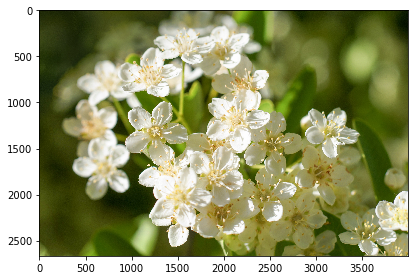

In [172]:
path = 'small flo.jpg'
image = imread(path)
type(image)
imshow(image)


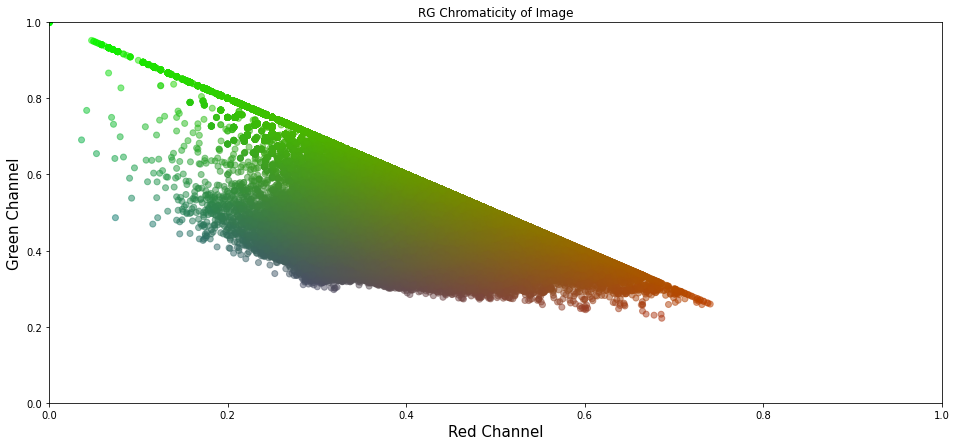

In [173]:
plot_RG_chromaticity_space(image, 'RG Chromaticity of Image')

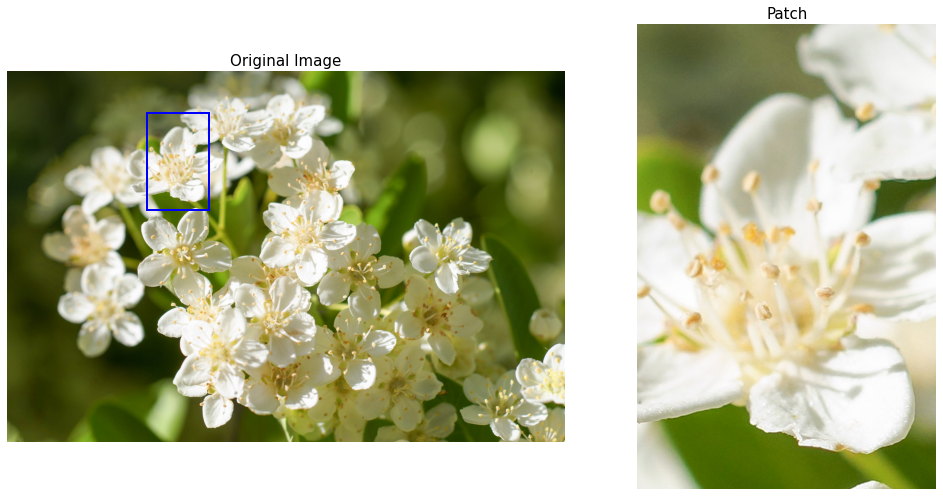

In [174]:
patch = image[300:1000, 1000:1450]
displayPatch(image, [300, 1000, 1000, 1450], patch)

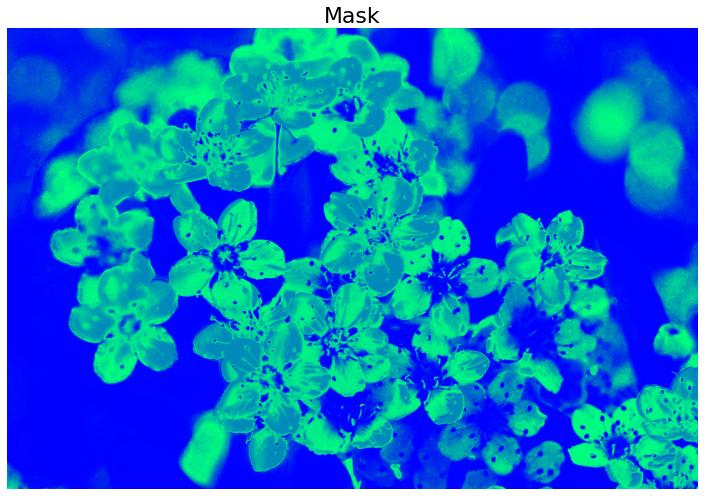

In [175]:

mask = rg_patch(image, patch, True)

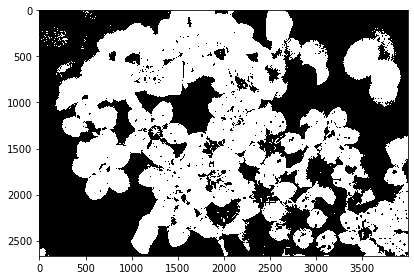

In [176]:
binaryMask = binarize(mask)
imshow(binaryMask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


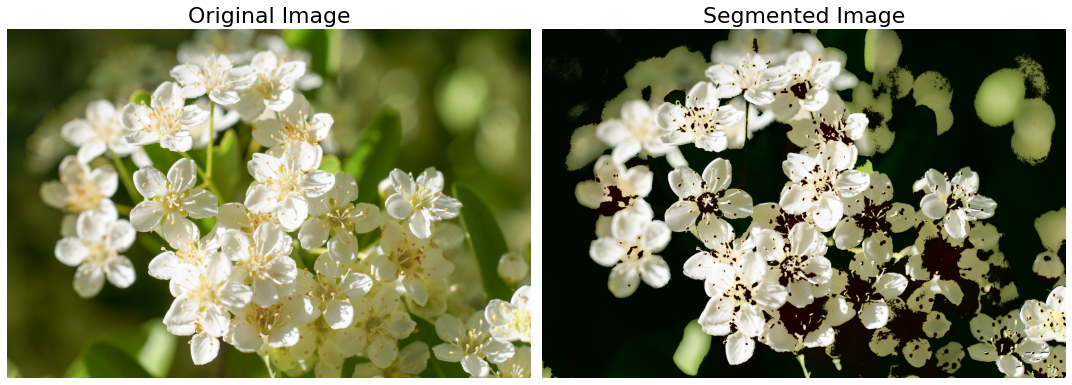

In [177]:
segment(image, binaryMask)

### Experiment 2: Mushroom Image (Outlier)

In [154]:
path = 'mushroom.jpg'
image = imread(path)
r,g = RG_chromaticity(image)
# imshow(r + g)
# plot_RG_chromaticity_space(image, 'RG Chromaticity Scatter Plot')

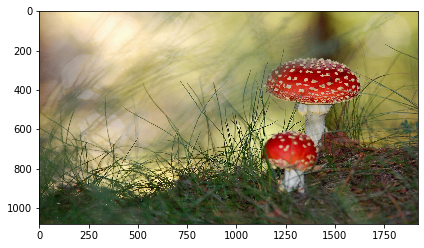

In [110]:
imshow(image)

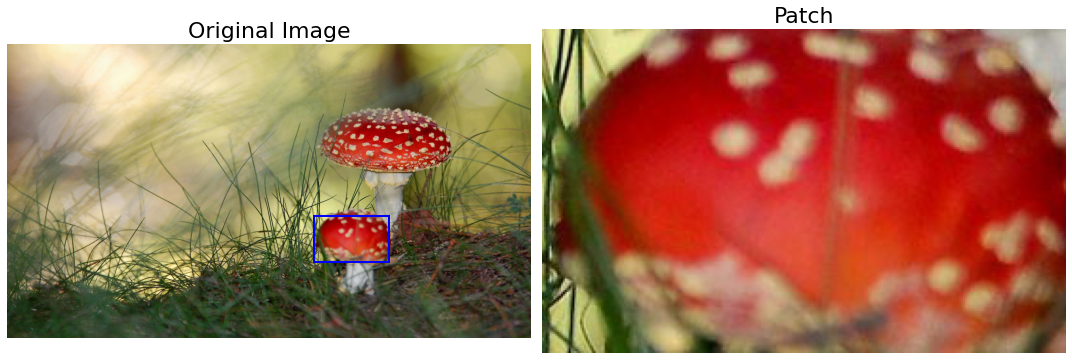

In [159]:
patch = image[630:800, 1125:1400]
# imshow(patch)
displayPatch(image,[630, 800, 1125, 1400] ,patch)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


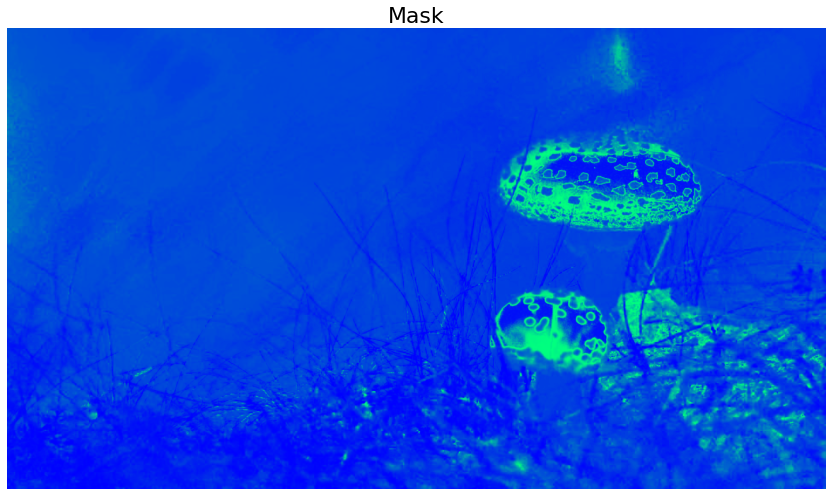

In [160]:
mask = rg_patch(image, patch, True)

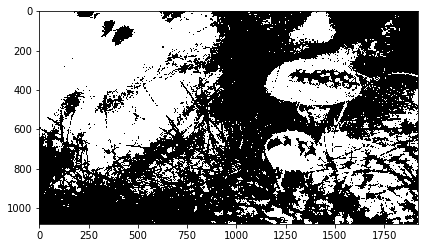

In [161]:
binaryMask = binarize(mask)
imshow(binaryMask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


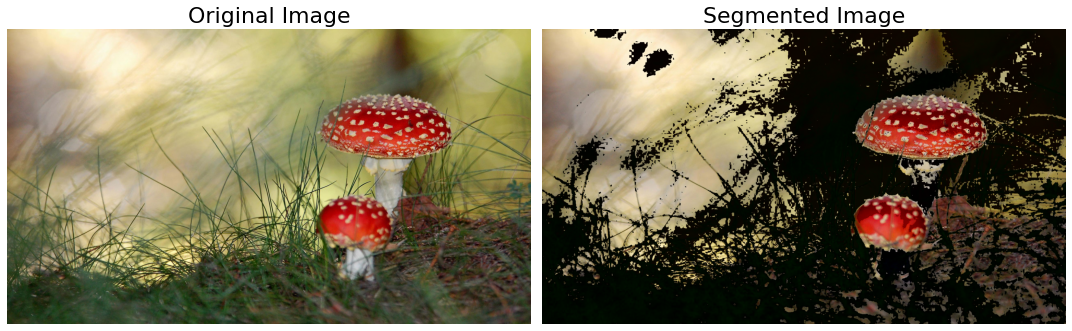

In [162]:
segment(image, binaryMask)

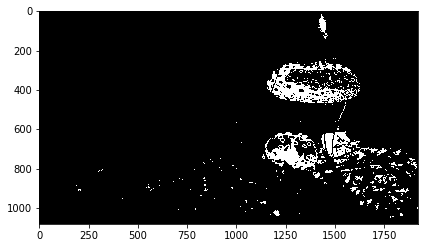

In [163]:
binaryMask = binarize(mask, 1.5)
imshow(binaryMask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


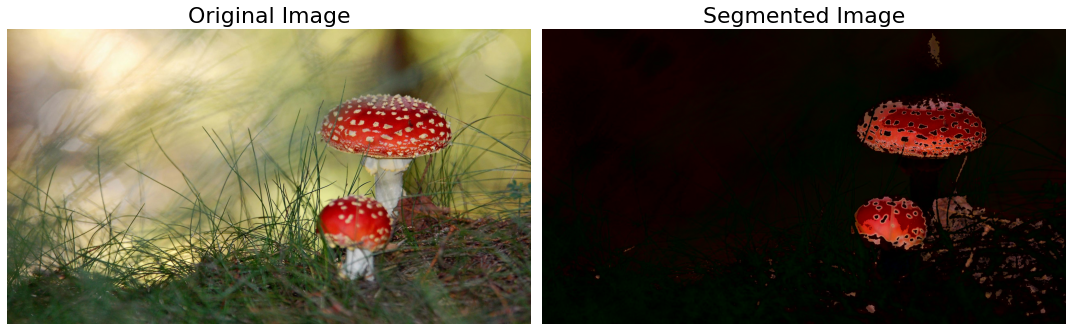

In [133]:
segment(image, binaryMask)

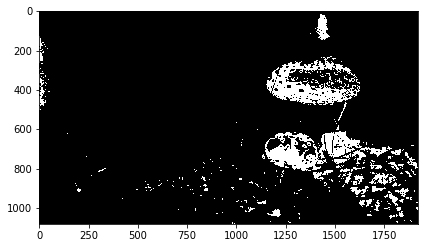

In [128]:
binaryMask = binarize(mask, 0.9)
imshow(binaryMask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


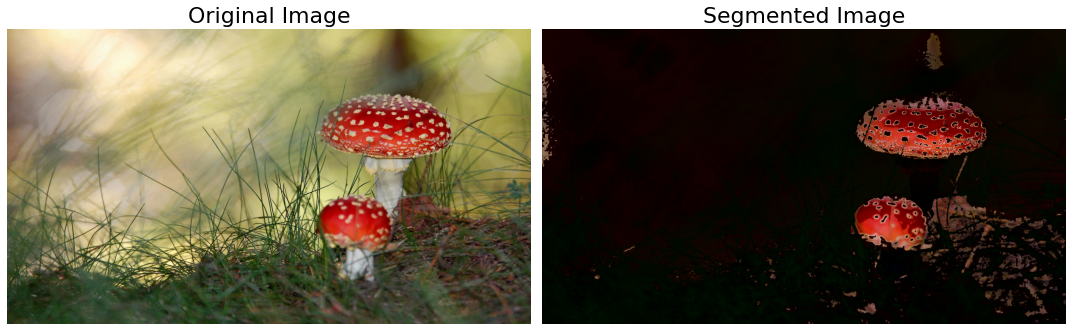

In [129]:
segment(image, binaryMask)